# Технологический процесс получения золота

Для эффективной работы промышленных предприятий необходимо разработать модель, которая может предсказывать коэффициент восстановления золота из золотосодержащей руды на основе данных о параметрах добычи и очистки. Модель поможет оптимизировать производство, чтобы не запускать предприятие с убыточными характеристиками.

## План работы

### Шаг 1. Загрузка и подготовка данных
- [1. Импорт библиотек, загрузка файлов, изучение общей информации](#section1)
- [2. Проверка корректности расчета эффективности обогащения](#section2)
- [3. Удаление лишних признаков, добавление целевых признаков в тестовую выборку, обработка пропусков](#section3)

### Шаг 2. Анализ данных
- [1. Анализ изменения концентрации металлов на каждом этапе](#section4)
- [2. Сравнение размеров гранул сырья в тренировочной и тестовой выборках](#section5)
- [3. Выявление и обработка аномальных значений в суммарных концентрация веществ на каждом этапе](#section6)

### Шаг 3. Построение модели
- [1. Создание функций для определения эффективности обогащения, выделение признаков и целевых признаков](#section7)
- [2. Создание функций для выполнения всех вычислений, обучения моделей, получения результатов](#section8)
- [3. Выявление только важных признаков, обучение различных моделей, выбор лучшей модели](#section9)
- [4. Проверка лучшей модели на тестовых данных](#section10)
- [5. Проверка модели на адекватность](#section11)

### Шаг 1. Загрузка и подготовка данных

<a id='section1'></a>

#### 1. Импорт библиотек, загрузка файлов, изучение общей информации

Для начала импортируем все библиотеки, потребующиеся в данной работе.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import make_scorer
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_score
import lightgbm as lgb
from sklearn.feature_selection import RFECV

Далее прочитаем файлы с данными и изучим общую информацию.

In [2]:
# Пути к файлам на локальком компьютере
paths = ['datasets/gold_recovery_train.csv',
         'datasets/gold_recovery_test.csv',
         'datasets/gold_recovery_full.csv']
# Пути к файлам в интернете
paths_net = ['is_hidden',
             'is_hidden',
             'is_hidden'
            ]
# Пробуем прочитать локальный файл
try:
    df_train = pd.read_csv(paths[0])
    df_test = pd.read_csv(paths[1])
    df_full = pd.read_csv(paths[2])
# Если не получилось - читаем из интернета
except:
    df_train = pd.read_csv(paths_net[0])
    df_test = pd.read_csv(paths_net[1])
    df_full = pd.read_csv(paths_net[2])

In [3]:
df_train.info()
df_train.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16860 entries, 0 to 16859
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                16860 non-null  object 
 1   final.output.concentrate_ag                         16788 non-null  float64
 2   final.output.concentrate_pb                         16788 non-null  float64
 3   final.output.concentrate_sol                        16490 non-null  float64
 4   final.output.concentrate_au                         16789 non-null  float64
 5   final.output.recovery                               15339 non-null  float64
 6   final.output.tail_ag                                16794 non-null  float64
 7   final.output.tail_pb                                16677 non-null  float64
 8   final.output.tail_sol                               16715 non-null  float64


,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,...,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
1,2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,...,13.992281,-505.503262,11.950531,-501.331529,10.039245,-500.169983,7.984757,-500.582168,13.998353,-599.787184
2,2016-01-15 02:00:00,6.055926,10.213995,5.383759,42.657501,68.116445,10.507046,0.953716,16.208849,2.257889,...,14.015015,-502.520901,11.912783,-501.133383,10.070913,-500.129135,8.013877,-500.517572,14.028663,-601.427363
3,2016-01-15 03:00:00,6.047977,9.977019,4.858634,42.689819,68.347543,10.422762,0.883763,16.532835,2.146849,...,14.036510,-500.857308,11.999550,-501.193686,9.970366,-499.201640,7.977324,-500.255908,14.005551,-599.996129
4,2016-01-15 04:00:00,6.148599,10.142511,4.939416,42.774141,66.927016,10.360302,0.792826,16.525686,2.055292,...,14.027298,-499.838632,11.953070,-501.053894,9.925709,-501.686727,7.894242,-500.356035,13.996647,-601.496691


In [4]:
df_test.info()
df_test.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5856 entries, 0 to 5855
Data columns (total 53 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   date                                        5856 non-null   object 
 1   primary_cleaner.input.sulfate               5554 non-null   float64
 2   primary_cleaner.input.depressant            5572 non-null   float64
 3   primary_cleaner.input.feed_size             5856 non-null   float64
 4   primary_cleaner.input.xanthate              5690 non-null   float64
 5   primary_cleaner.state.floatbank8_a_air      5840 non-null   float64
 6   primary_cleaner.state.floatbank8_a_level    5840 non-null   float64
 7   primary_cleaner.state.floatbank8_b_air      5840 non-null   float64
 8   primary_cleaner.state.floatbank8_b_level    5840 non-null   float64
 9   primary_cleaner.state.floatbank8_c_air      5840 non-null   float64
 10  primary_clea

,date,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-09-01 00:59:59,210.800909,14.993118,8.080000,1.005021,1398.981301,-500.225577,1399.144926,-499.919735,1400.102998,...,12.023554,-497.795834,8.016656,-501.289139,7.946562,-432.317850,4.872511,-500.037437,26.705889,-499.709414
1,2016-09-01 01:59:59,215.392455,14.987471,8.080000,0.990469,1398.777912,-500.057435,1398.055362,-499.778182,1396.151033,...,12.058140,-498.695773,8.130979,-499.634209,7.958270,-525.839648,4.878850,-500.162375,25.019940,-499.819438
2,2016-09-01 02:59:59,215.259946,12.884934,7.786667,0.996043,1398.493666,-500.868360,1398.860436,-499.764529,1398.075709,...,11.962366,-498.767484,8.096893,-500.827423,8.071056,-500.801673,4.905125,-499.828510,24.994862,-500.622559
3,2016-09-01 03:59:59,215.336236,12.006805,7.640000,0.863514,1399.618111,-498.863574,1397.440120,-499.211024,1400.129303,...,12.033091,-498.350935,8.074946,-499.474407,7.897085,-500.868509,4.931400,-499.963623,24.948919,-498.709987
4,2016-09-01 04:59:59,199.099327,10.682530,7.530000,0.805575,1401.268123,-500.808305,1398.128818,-499.504543,1402.172226,...,12.025367,-500.786497,8.054678,-500.397500,8.107890,-509.526725,4.957674,-500.360026,25.003331,-500.856333


In [5]:
df_full.info()
df_full.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22716 entries, 0 to 22715
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                22716 non-null  object 
 1   final.output.concentrate_ag                         22627 non-null  float64
 2   final.output.concentrate_pb                         22629 non-null  float64
 3   final.output.concentrate_sol                        22331 non-null  float64
 4   final.output.concentrate_au                         22630 non-null  float64
 5   final.output.recovery                               20753 non-null  float64
 6   final.output.tail_ag                                22633 non-null  float64
 7   final.output.tail_pb                                22516 non-null  float64
 8   final.output.tail_sol                               22445 non-null  float64


,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,...,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
1,2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,...,13.992281,-505.503262,11.950531,-501.331529,10.039245,-500.169983,7.984757,-500.582168,13.998353,-599.787184
2,2016-01-15 02:00:00,6.055926,10.213995,5.383759,42.657501,68.116445,10.507046,0.953716,16.208849,2.257889,...,14.015015,-502.520901,11.912783,-501.133383,10.070913,-500.129135,8.013877,-500.517572,14.028663,-601.427363
3,2016-01-15 03:00:00,6.047977,9.977019,4.858634,42.689819,68.347543,10.422762,0.883763,16.532835,2.146849,...,14.036510,-500.857308,11.999550,-501.193686,9.970366,-499.201640,7.977324,-500.255908,14.005551,-599.996129
4,2016-01-15 04:00:00,6.148599,10.142511,4.939416,42.774141,66.927016,10.360302,0.792826,16.525686,2.055292,...,14.027298,-499.838632,11.953070,-501.053894,9.925709,-501.686727,7.894242,-500.356035,13.996647,-601.496691


Тренировочный и полный датасеты содержат по 87 столбцов. Тестовый столбец содержит 53 столбца. Во многих столбцах есть пропуски. Все столбцы, кроме столбца date, имеют вещественный тип. Столбец date имеет строковый тип. Строки расположены по увеличению значения в столбце date, значения других столбцов в соседних строках в большинстве случаев отличаются не сильно.

<a id='section2'></a>

#### 2. Проверка корректности расчета эффективности обогащения

Проверим, что эффективность обогащения рассчитана правильна. Для этого рассчитаем её самостоятельно на обучающей выборке и определим MAE между расчетными данными, и теми данными, что нам даны.

In [6]:
# Рассчитаем эффективность обогащения
df_train['rougher.output.recovery_calc'] = (df_train['rougher.output.concentrate_au'] * 
                                            (df_train['rougher.input.feed_au'] - df_train['rougher.output.tail_au']) / 
                                            (df_train['rougher.input.feed_au'] * 
                                             (df_train['rougher.output.concentrate_au'] - df_train['rougher.output.tail_au'])) *
                                            100
                                            )
# Сделаем датасет, состоящий только из двух исследуемых столбцов,
# удалим пропуски для расчета MAE
df_mae = df_train[['rougher.output.recovery','rougher.output.recovery_calc']].dropna()
# Рассчитаем абсолютное отклонение в каждой строке
df_mae['absolute_error'] = df_mae['rougher.output.recovery']- df_mae['rougher.output.recovery_calc']
# Выведем распределение величин
df_mae.describe()

,rougher.output.recovery,rougher.output.recovery_calc,absolute_error
count,14287.000000,14287.000000,1.428700e+04
mean,82.394201,82.394201,1.168116e-16
std,15.096808,15.096808,1.429528e-14
min,0.000000,-0.000000,-6.394885e-14
25%,79.818372,79.818372,-1.421085e-14
50%,85.235997,85.235997,0.000000e+00
75%,90.131691,90.131691,1.421085e-14
max,100.000000,100.000000,7.105427e-14


In [7]:
print('Средняя абсолютная ошибка =', 
      mean_absolute_error(df_mae['rougher.output.recovery'], df_mae['rougher.output.recovery_calc'])
     )

Средняя абсолютная ошибка = 9.444891926100695e-15


Как видно из полученных данных, разница между расчетными и исходными данными крайне мала, из чего делаем вывод, что в исходных данных эффективность обогащения рассчитана верно.

<a id='section3'></a>

#### 3. Удаление лишних признаков, добавление целевых признаков в тестовую выборку, обработка пропусков

В тестовой выборке столбцов значительно меньше, чем в тренировочной и полной. В тестовой выборке не хватает данных об выходных значениях некоторых величин на каждом этапе. Очевидно, это означает, что многие признаки рассчитываются уже после сбора данных с датчиков. Так как наша задача на основе входных данных получить эффективности обогащения на каждом этапе, для обучения моделей нам не нужны выходные данные на каждом этапе. То есть столбцы, которые есть в тренировочной выборке, но нет в тестовой - можно удалить из тренировочной выборки и общих данных. Перед этим необходимо добавить в тестовый датасет целевые признаки (значение recovery) для всех этапов.

In [8]:
# Выведем на экран список столбцов, отсутствующих в тестовом датасете,
# перед этим создадим множества из списков столбцов и найдем разницу между ними
df_train_columns_set = set(df_train.columns)
df_test_columns_set = set(df_test.columns)
set.difference(df_train_columns_set, df_test_columns_set)

{'final.output.concentrate_ag',
 'final.output.concentrate_au',
 'final.output.concentrate_pb',
 'final.output.concentrate_sol',
 'final.output.recovery',
 'final.output.tail_ag',
 'final.output.tail_au',
 'final.output.tail_pb',
 'final.output.tail_sol',
 'primary_cleaner.output.concentrate_ag',
 'primary_cleaner.output.concentrate_au',
 'primary_cleaner.output.concentrate_pb',
 'primary_cleaner.output.concentrate_sol',
 'primary_cleaner.output.tail_ag',
 'primary_cleaner.output.tail_au',
 'primary_cleaner.output.tail_pb',
 'primary_cleaner.output.tail_sol',
 'rougher.calculation.au_pb_ratio',
 'rougher.calculation.floatbank10_sulfate_to_au_feed',
 'rougher.calculation.floatbank11_sulfate_to_au_feed',
 'rougher.calculation.sulfate_to_au_concentrate',
 'rougher.output.concentrate_ag',
 'rougher.output.concentrate_au',
 'rougher.output.concentrate_pb',
 'rougher.output.concentrate_sol',
 'rougher.output.recovery',
 'rougher.output.recovery_calc',
 'rougher.output.tail_ag',
 'rougher.out

Можно заметить, что действительно все недоступные в тестовой выборке признаки имеют в названии слова output или calculation, то есть это выходные и расчетные данные, которые не требуются для обучения модели.

In [9]:
# Сначала добавим в тестовую выборку целевые признаки
df_test = df_test.merge(df_full[['date', 'rougher.output.recovery', 'final.output.recovery']], 'left', 'date')
# Далее оставим в тренировочном и полном датасете только признаки,
# присутствующие в тестовом датасете
df_train = df_train[df_test.columns]

Далее предобработаем данные. Данные в столбце date приведем к datetime типу. Ранее было сказано, что данные в соседних строчках очень похожи, а значит со временем меняются не сильно. Это позволит заполнить пропуски на основе соседних значений. Однако пропуски в целевых признаках заполнять некорректно, так как это может исказить результат обучения модели. Такие наблюдения лучше удалить.

In [10]:
# Оценим количество пропусков в столбцах
print('Пропуски в тренировочной выборке')
print(df_train.isna().sum().sort_values(ascending=False) / len(df_train))
print('Пропуски в тестовой выборке')
print(df_test.isna().sum().sort_values(ascending=False) / len(df_train))

Пропуски в тренировочной выборке
rougher.output.recovery                       0.152610
rougher.input.floatbank11_xanthate            0.112930
final.output.recovery                         0.090214
primary_cleaner.input.sulfate                 0.077521
primary_cleaner.input.depressant              0.074852
rougher.input.floatbank10_sulfate             0.061922
primary_cleaner.input.xanthate                0.058422
rougher.input.floatbank11_sulfate             0.036951
rougher.state.floatbank10_e_air               0.035765
rougher.input.feed_rate                       0.030427
rougher.input.feed_size                       0.024733
secondary_cleaner.state.floatbank2_a_air      0.021530
rougher.input.floatbank10_xanthate            0.020522
rougher.input.feed_sol                        0.017319
rougher.input.feed_pb                         0.013523
secondary_cleaner.state.floatbank2_b_air      0.009193
secondary_cleaner.state.floatbank4_a_air      0.007651
secondary_cleaner.state.floatban

In [11]:
# Удалим наблюдения с пропусками в целевых признаках
df_train = df_train[~df_train['rougher.output.recovery'].isna() & ~df_train['final.output.recovery'].isna()]
df_test = df_test[~df_test['rougher.output.recovery'].isna() & ~df_test['final.output.recovery'].isna()]
df_full = df_full[~df_full['rougher.output.recovery'].isna() & ~df_full['final.output.recovery'].isna()]

# Заполним пропуски на основе предыдущих значений для остальных признаков
df_train.fillna(method='ffill', inplace=True)
df_test.fillna(method='ffill', inplace=True)
df_full.fillna(method='ffill', inplace=True)

# Преобразуем столбец date
df_train['date'] = pd.to_datetime(df_train['date'], format='%Y-%m-%d %H:%M:%S')
df_test['date'] = pd.to_datetime(df_test['date'], format='%Y-%m-%d %H:%M:%S')
df_full['date'] = pd.to_datetime(df_full['date'], format='%Y-%m-%d %H:%M:%S')

### Вывод

Исходные данные были изучены, эффективность обогащения в них посчитана верно. В тестовые данные были добавлены целевые признаки, из тренировочных удалены все ненужные признаки. Далее все данные были предобработаны.

### Шаг 2. Анализ данных

<a id='section4'></a>

#### 1. Анализ изменения концентрации металлов на каждом этапе

Сначала изучим, как меняется концентрация металлов на различных этапах.

In [12]:
# Для визуализации необходимо перевести датафрейм в вертикальный вид
# Список колонок для визуализации
columns = [ 'rougher.input.feed_ag',
             'rougher.input.feed_pb',             
             'rougher.input.feed_au',
             'rougher.output.concentrate_ag',
             'rougher.output.concentrate_pb',             
             'rougher.output.concentrate_au',
             'primary_cleaner.output.concentrate_ag',
             'primary_cleaner.output.concentrate_pb',             
             'primary_cleaner.output.concentrate_au',
             'final.output.concentrate_ag',
             'final.output.concentrate_pb',             
             'final.output.concentrate_au'
          ]
# Список металлов
metals = ['ag', 'pb', 'au']
# Названия этапов
stages = ['Сырьё', 'Флотация', 'Первый этап очистки', 'Второй этап очистки']
# Получим срез исходного датафрейма по нужным колонкам
df_vert = df_full[columns]
# Делаем датафрейм вертикальным, удаляем лишние колонки
df_vert = df_vert.stack().reset_index(name='concentration').drop(['level_0', 'level_1'],axis=1)
# Указываем названия металлов
df_vert['metal'] = metals * len(df_full) * len(stages)
# Указываем название этапов
df_vert['stage'] = pd.concat([pd.Series(stages).repeat(len(metals))] * len(df_full)).reset_index(drop=True)
df_vert

,concentration,metal,stage
0,6.100378,ag,Сырьё
1,2.284912,pb,Сырьё
2,6.486150,au,Сырьё
3,11.500771,ag,Флотация
4,7.101074,pb,Флотация
...,...,...,...
233263,11.650285,pb,Первый этап очистки
233264,30.356618,au,Первый этап очистки
233265,3.598375,ag,Второй этап очистки
233266,11.737832,pb,Второй этап очистки


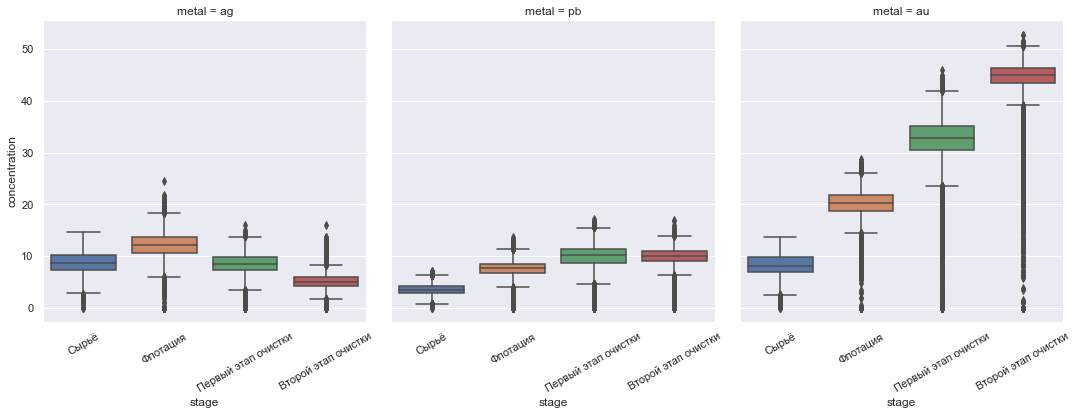

In [13]:
sns.set()

# Визуализируем данные
g = sns.catplot(y='concentration',
                x='stage',
                col='metal',
                kind='box',
                data=df_vert)
g.set_xticklabels(rotation=30)
plt.show()

Как видно из представленных графиков, доля au (золота) последовательно увеличивается на каждом этапе, что говорит об эффективности технологического процесса: доля золота в конечном продукте более чем в 4 раза больше, чем в исходном сырье. Доля ag (серебра) увеличивается после флотации, после каждого этапа очистки уменьшается. Конечная доля серебра меньше, чем в исходном сырье. Доля pb (свинца) после флотации увеличивается примерно в 2 раза, после очистки ещё немного увеличивается. Также на представленных графиках видно распределение концентраций всех металлов на каждой фазе, можно заметить аномальные значения, близкие к нулю, исследуем этот момент далее.

<a id='section5'></a>

#### 2. Сравнение размеров гранул сырья в тренировочной и тестовой выборках

Теперь сравним распределения размеров гранул сырья в тренировочной и тестовой выборке, что бы определить адекватность дальнейшей оценки.

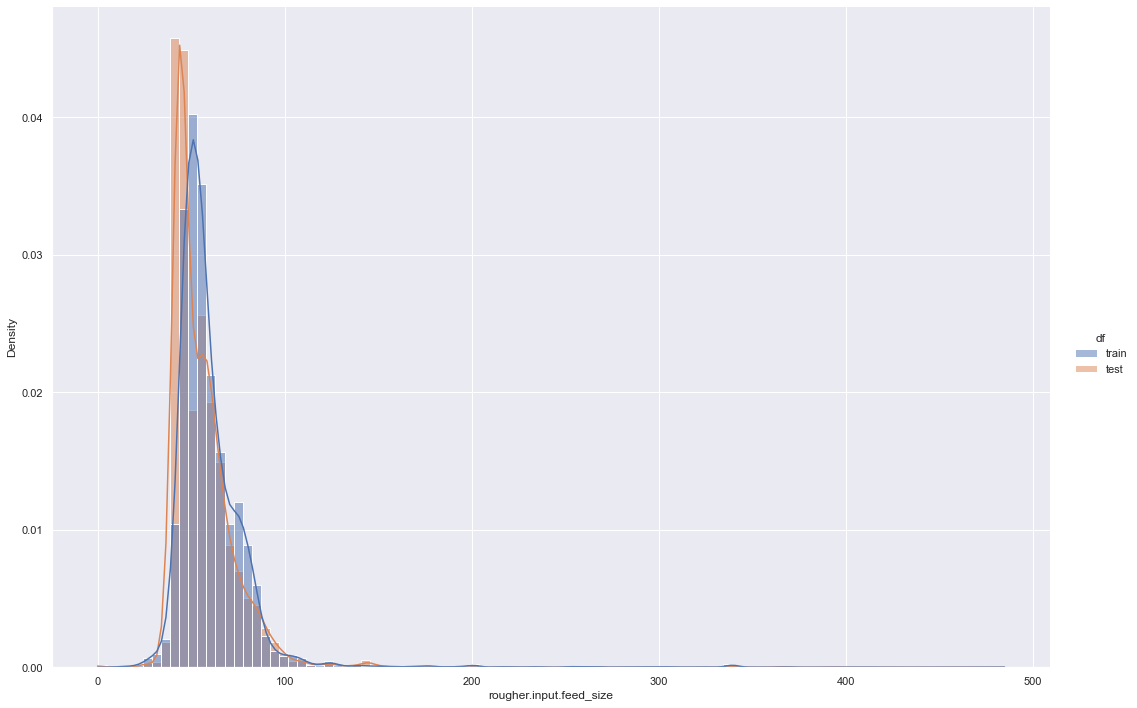

In [14]:
# Объединим данные
df_feed_size = pd.concat([df_train.assign(df='train'), df_test.assign(df='test')])

# Построим распределение размера гранул сырья в тренировочной и тестовой выборках
sns.displot(data=df_feed_size,
            x='rougher.input.feed_size',
            hue='df',
            bins=100,
            kde=True,
            stat="density",
            common_norm=False,
            height=10,
            aspect=1.5
           )
plt.show()

Распределения размеров гранул сырья в обеих выборках примерно одинаковое, значит оценка модели будет верной.

<a id='section6'></a>

#### 3. Выявление и обработка аномальных значений в суммарных концентрация веществ на каждом этапе

Теперь необходимо проанализровать распределение суммарных концентраций веществ на каждой стадии обработки.

In [15]:
# На каждом этапе выделим признаки с концентрацией веществ
cols = ['rougher.input.feed_ag',
        'rougher.input.feed_pb',
        'rougher.input.feed_sol',
        'rougher.input.feed_au'
       ]
# Создадим колонки с суммарными концетрациями
df_full['Сырьё'] = df_full[cols].sum(axis=1)
cols = ['rougher.output.concentrate_ag',
        'rougher.output.concentrate_pb',
        'rougher.output.concentrate_sol',
        'rougher.output.concentrate_au'
       ]
df_full['Флотация'] = df_full[cols].sum(axis=1)
cols = ['primary_cleaner.output.concentrate_ag',
        'primary_cleaner.output.concentrate_pb',
        'primary_cleaner.output.concentrate_sol',
        'primary_cleaner.output.concentrate_au',
       ]
df_full['Первый этап очистки'] = df_full[cols].sum(axis=1)
cols = ['final.output.concentrate_ag',
        'final.output.concentrate_pb',
        'final.output.concentrate_sol',
        'final.output.concentrate_au',
       ]
df_full['Второй этап очистки'] = df_full[cols].sum(axis=1)
# Переведём в long-data формат
df_melted = pd.melt(df_full,
                    value_vars=['Сырьё', 'Флотация', 'Первый этап очистки', 'Второй этап очистки'], 
                    var_name='Этап',
                    value_name='Суммарная концентрация')

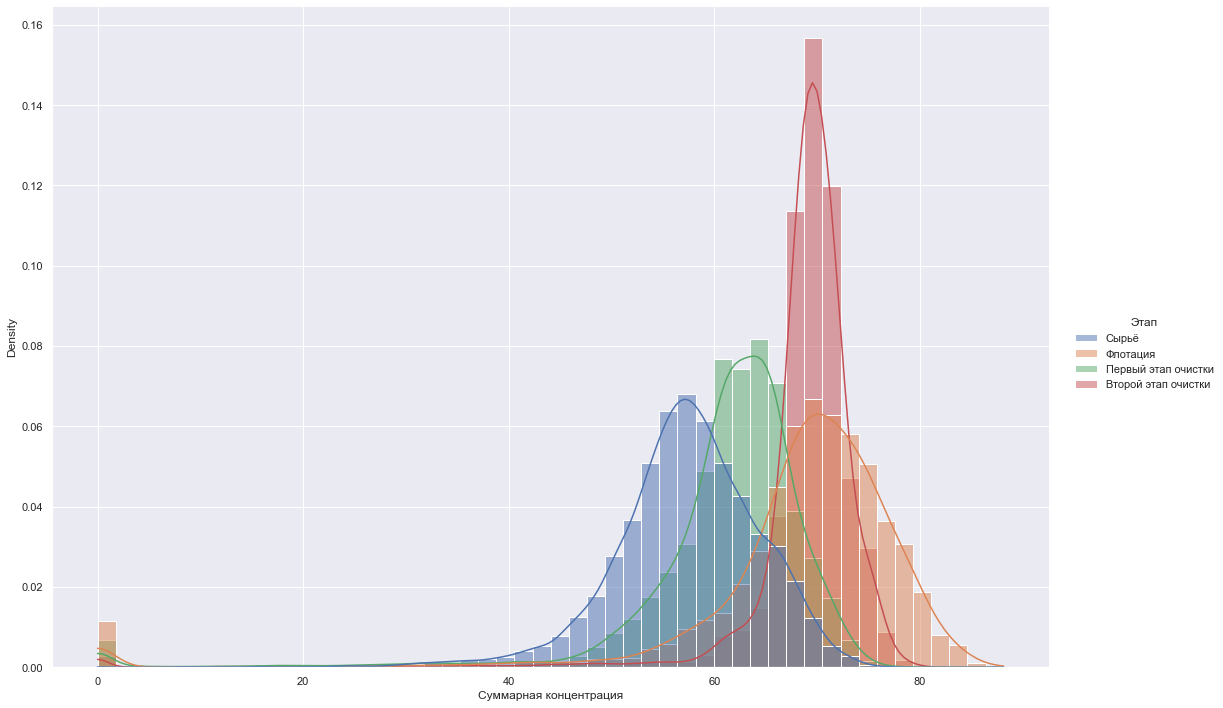

In [16]:
# Построим распределение суммарных концентраций на каждом этапе
sns.displot(data=df_melted,
            x='Суммарная концентрация',
            hue='Этап',
            bins=50,
            kde=True,
            stat="density",
            common_norm=False,
            height=10,
            aspect=1.5
           )
plt.show()

В распределениях присутствуют нулевые суммарные концентрации веществ. Очевидно, что такие наблюдения отрицательно скажутся на качестве модели. Поэтому оставим в тренировочной и тестовой выборках только наблюдения с положительными суммарными концентрациями.

In [17]:
# Определим время и даты, в которые возникали артефакты
dates = df_full[(df_full['Сырьё']<1) | 
                (df_full['Флотация']<1) | 
                (df_full['Первый этап очистки']<1) | 
                (df_full['Второй этап очистки']<1)
               ]['date']

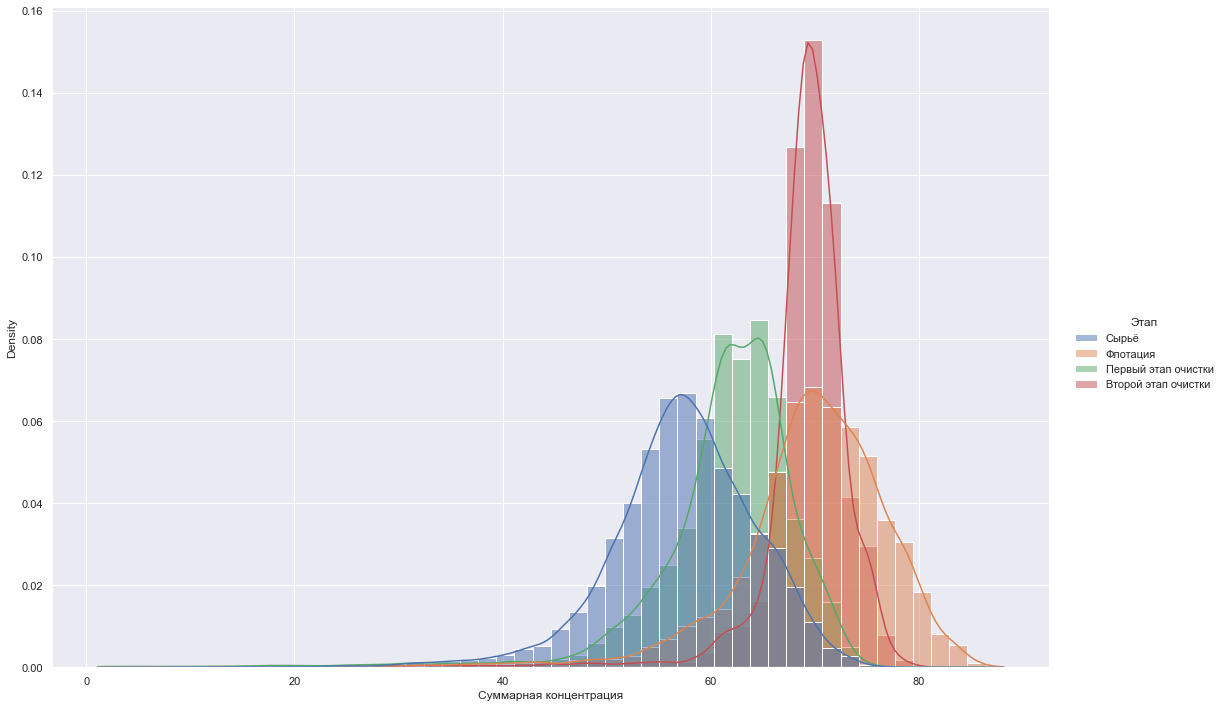

In [18]:
# Очистим данные от артефактов
df_test = df_test.query('date not in @dates').reset_index(drop=True)
df_train = df_train.query('date not in @dates').reset_index(drop=True)
df_full = df_full.query('date not in @dates').reset_index(drop=True)

# Переведём в long-data формат
df_melted = pd.melt(df_full,
                    value_vars=['Сырьё', 'Флотация', 'Первый этап очистки', 'Второй этап очистки'], 
                    var_name='Этап',
                    value_name='Суммарная концентрация')

# Убедимся, что распределение суммарных концентраций на каждом этапе улучшилось
g = sns.displot(data=df_melted,
            x='Суммарная концентрация',
            hue='Этап',
            bins=50,
            kde=True,
            stat="density",
            common_norm=False,
            height=10,
            aspect=1.5
           )
plt.show()

### Вывод

Был проведён исследовательский анализ данных, в ходе которого было изучено, как меняются распределения каждого металла и суммарных концентраций на каждой фазе обработки. Были выявлены и удалены наблюдения с нулевыми суммарными концентрациями. Также было осуществлено сравнение размеров исходного сырья в тестовой и тренировочной выборках, распределения оказались похожими.

### Шаг 3. Построение модели

<a id='section7'></a>

#### 1. Создание функций для определения эффективности обогащения, выделение признаков и целевых признаков

Создадим модель, предсказывающую эффективность обогащения золота на основе признаков, оставшихся в тренировочной выборке. Для оценки эффективности модели воспользуемся метрико sMAPE. Для начала напишем функции вычисления sMAPE на каждом этапе и итогового sMAPE.

In [19]:
# Опишем функцию вычисления sMAPE
def sMAPE(y, y_pred):
    y = np.array(y)
    y_pred = np.array(y_pred)
    mean = np.mean(np.abs(y - y_pred) * 100 /
                   ((np.abs(y) + np.abs(y_pred)) / 2))
    return mean
# Опишем функцию вычисления итогового sMAPE
def sMAPE_sum(sMAPE_rough, sMAPE_final):
    return 0.25 * sMAPE_rough + 0.75 * sMAPE_final

Выделим признаки и целевой признак

In [20]:
X_train = df_train.drop(['date', 'rougher.output.recovery', 'final.output.recovery'], axis=1)
y1_train = df_train['rougher.output.recovery']
y2_train = df_train['final.output.recovery']
X_test = df_test.drop(['date', 'rougher.output.recovery', 'final.output.recovery'], axis=1)
y1_test = df_test['rougher.output.recovery']
y2_test = df_test['final.output.recovery']

Создадим собственную метрику на основе функции sMAPE

In [21]:
sMAPE_score = make_scorer(sMAPE, greater_is_better=False)

<a id='section8'></a>

#### 2. Создание функций для выполнения всех вычислений, обучения моделей, получения результатов

Для дальнейших исследований создадим все необходимые функции.

In [22]:
def cross_val(n_splits, X, y, random_state=0):
    '''
    Функция для разделения исходной выборки на тренировочную и валидационную
    для выполнения кросс-валидации
    n_splits - число разделений
    X - признаки
    y - целевой признак
    '''
    cv = list(KFold(n_splits=n_splits, shuffle=True, random_state=random_state) \
              .split(X, y))
    return cv

def fit_predict(model, X, y, random_state=0, parameters=None):
    '''
    Функция определения score модели кросс-валидацией, возвращает обученую модель
    model - модель регрессии
    X - признаки
    y - целевой признак
    parameters - словарь с варьируемыми параметрами. Если не указан - используется
    базовый эстиматор, если указан - используется RandomizedSearchCV
    '''
    if parameters is None:
        cv = cross_val(5, X, y, random_state)
        smape = cross_val_score(model, X, y, scoring=sMAPE_score).mean() * (-1)
        model.fit(X, y)
    else:
        model = rand_search(model,
                            parameters,
                            X,
                            y,
                            sMAPE_score,
                            5,
                            100,
                            random_state)
        model.fit(X, y)
        smape = model.best_score_ * (-1)
    print('sMAPE на тренировочных данных =', smape)
    return model, smape

def feature_selection(X, y, X_test, scoring, random_state=0):
    '''
    Функция определяет важность признаков, 
    возвращает самые важные тренировочные и тестовые признаки
    X - признаки
    y - целевой признак
    X_test - признаки тестовой выборки
    '''
    model = lgb.LGBMRegressor(random_state=random_state)
    model.fit(X, y)
    feat_import = pd.DataFrame({'Feature_Importance':model.feature_importances_, 'Feature':X.columns})
    
    kf = cross_val(10, X, y, random_state)
    rfecv = RFECV(
        estimator=model, 
        step=1,
        cv=kf,
        verbose=0,
        scoring=scoring,
        n_jobs=-1
    )
    rfecv.fit(X, y)
    X_columns_before = set(X.columns)
    X_columns_count_before = len(X_columns_before)
    X = X.loc[:, rfecv.support_]
    X_test = X_test.loc[:, rfecv.support_]
    X_columns_after = set(X.columns)
    X_columns_count_after = len(X_columns_after)
    
    # Построение графика важности признаков
    g = sns.catplot(x='Feature',
                    y='Feature_Importance',
                    data=feat_import.sort_values(by='Feature_Importance',ascending=False),
                    kind='bar',
                    height=10,
                    aspect=1.5,
                   )
    plt.setp(g.ax.get_xticklabels(), rotation=90)
    vert_line(X_columns_count_after-0.5, g, 'red', 'Граница важности признаков')
    plt.show()    
    
    print('Исходное количество признаков = {}, количество признаков после оптимизации = {}'.format(X_columns_count_before,
                                                                                                   X_columns_count_after))
    print('Список наименее важных признаков:', set.difference(X_columns_before, X_columns_after))
    return X, X_test

def vert_line(x, g, color, text):
    '''
    Функция построения вертикальной линии на графике
    '''
    plt.axvline(x, color=color, linestyle='dashed', alpha=.4)
    g.ax.text(x-.5,
            100,
            text,
            color=color,
            size=10,
            rotation=90,
            ha='center'
           )

def rand_search(model, parameters, X, y, scoring, n_splits, n_iter, random_state=0):
    '''
    Функция для выполнения кросс-валидации, возвращает настроенную модель
    model - модель для обучения
    parameters - словарь с варьируемыми параметрами
    X - признаки
    y - целевой признак
    scoring - метрика для оптимизации
    n_splits - число разбиаений выборки
    n_iter - количество итерация поиска
    '''
    cv = cross_val(n_splits, X, y, random_state)
    model = RandomizedSearchCV(model,
                               parameters,
                               n_jobs=-1,                               
                               scoring=scoring,
                               cv=cv,
                               n_iter=n_iter,
                               random_state=random_state,
                               verbose=0
                              )
    return model

def sMAPE_sum_calc(model1, model2, X1, y1, X2, y2, random_state=0, parameters=None):
    '''
    Функция для вычисления итогового sMAPE
    model1 и model2 - модели для обученич
    Xi - признаки
    yi - целевой признак
    parameters - словарь с варьируемыми параметрами. Если не указан - используется
    базовый эстиматор, если указан - используется RandomizedSearchCV
    '''
    model1, smape_rough = fit_predict(model1, X1, y1, random_state, parameters)
    model2, smape_final = fit_predict(model2, X2, y2, random_state, parameters)
    print('Итоговое sMAPE =', sMAPE_sum(smape_rough, smape_final))
    return model1, model2

<a id='section9'></a>

#### 3. Выявление только важных признаков, обучение различных моделей, выбор лучшей модели

В качестве первого приближения обучим модель линейной регрессии на всех признаках

In [23]:
%%time
model = LinearRegression()
model1, model2 = sMAPE_sum_calc(model, model, X_train, y1_train, X_train, y2_train, 321)

sMAPE на тренировочных данных = 7.282138560672929
sMAPE на тренировочных данных = 11.027381160017397
Итоговое sMAPE = 10.091070510181279
Wall time: 351 ms


Теперь выделим только самые важные признаки. Так как для каждого целевого признака могут оказаться важными разные признаки, в итоге получим по два набора тренировочных и тестовых признаков.

Выявление важных признаков для первого целевого признака:


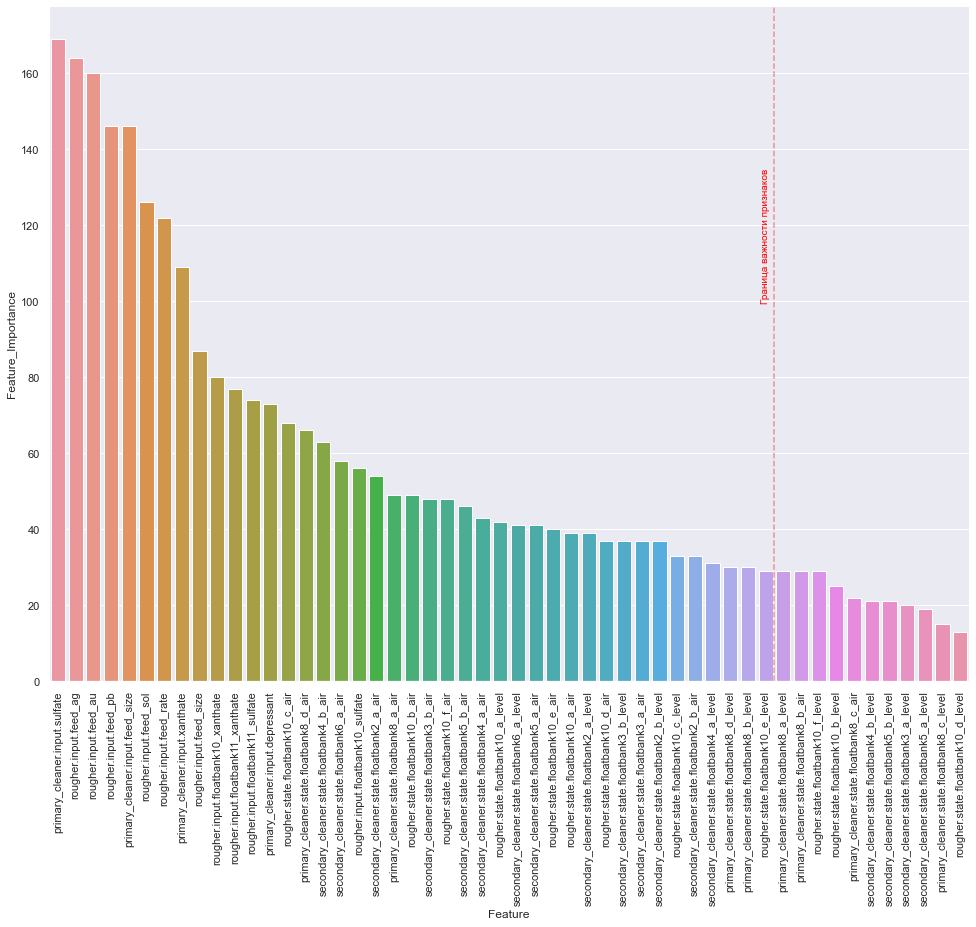

Исходное количество признаков = 52, количество признаков после оптимизации = 41
Список наименее важных признаков: {'primary_cleaner.state.floatbank8_b_level', 'secondary_cleaner.state.floatbank5_a_level', 'secondary_cleaner.state.floatbank4_b_level', 'primary_cleaner.state.floatbank8_a_level', 'secondary_cleaner.state.floatbank3_a_level', 'secondary_cleaner.state.floatbank4_a_level', 'primary_cleaner.state.floatbank8_c_level', 'rougher.state.floatbank10_e_level', 'rougher.state.floatbank10_d_level', 'secondary_cleaner.state.floatbank5_b_level', 'primary_cleaner.state.floatbank8_c_air'}
Wall time: 1min 18s


In [24]:
%%time
print('Выявление важных признаков для первого целевого признака:')
X1_train, X1_test = feature_selection(X_train, y1_train, X_test, sMAPE_score, 321)

Выявление важных признаков для второго целевого признака:


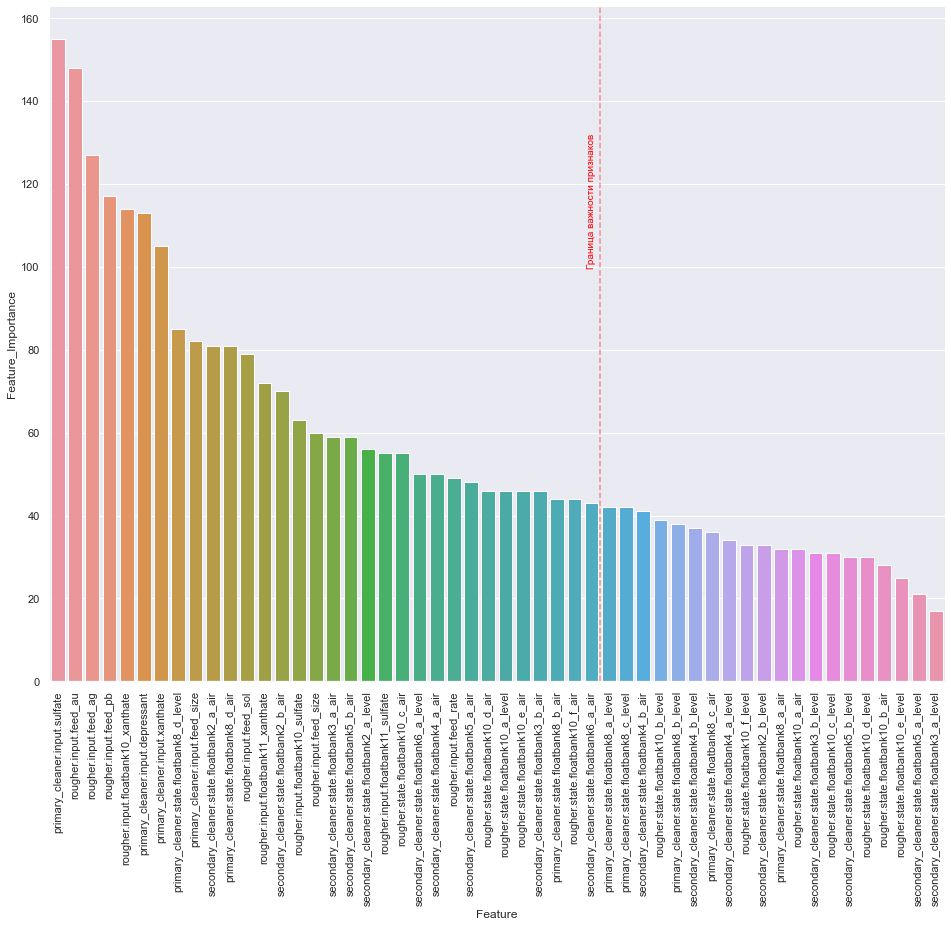

Исходное количество признаков = 52, количество признаков после оптимизации = 32
Список наименее важных признаков: {'primary_cleaner.state.floatbank8_a_air', 'rougher.state.floatbank10_f_level', 'secondary_cleaner.state.floatbank2_b_level', 'primary_cleaner.state.floatbank8_c_air', 'rougher.state.floatbank10_a_air', 'rougher.state.floatbank10_a_level', 'primary_cleaner.state.floatbank8_a_level', 'secondary_cleaner.state.floatbank4_b_air', 'rougher.state.floatbank10_e_level', 'primary_cleaner.state.floatbank8_b_level', 'secondary_cleaner.state.floatbank3_a_level', 'secondary_cleaner.state.floatbank4_a_level', 'rougher.state.floatbank10_e_air', 'rougher.state.floatbank10_d_level', 'secondary_cleaner.state.floatbank5_a_level', 'secondary_cleaner.state.floatbank4_b_level', 'rougher.state.floatbank10_b_air', 'rougher.state.floatbank10_c_level', 'secondary_cleaner.state.floatbank3_b_level', 'secondary_cleaner.state.floatbank5_b_level'}
Wall time: 1min 16s


In [25]:
%%time
print('Выявление важных признаков для второго целевого признака:')
X2_train, X2_test = feature_selection(X_train, y2_train, X_test, sMAPE_score, 321)

Для обоих целевых признаков были оставлены только самые важные признаки. Легко заметить, что наименее важными признаками являются признаки, в названии которых присутствует слово floatbank.

Проверим, как поменяется итоговое sMAPE при обучении модели линейной регрессии только на важных признаках.

In [26]:
%%time
model = LinearRegression()
model1, model2 = sMAPE_sum_calc(model, model, X1_train, y1_train, X2_train, y2_train, 321)

sMAPE на тренировочных данных = 6.853758536005801
sMAPE на тренировочных данных = 10.320854592146286
Итоговое sMAPE = 9.454080578111165
Wall time: 210 ms


Удалось снизить sMAPE на 0,64, уже результат. Теперь попробуем обучить модель дерева решений с использованием кросс-валидации.

In [27]:
%%time
model = DecisionTreeRegressor(random_state=321)
parameters = {'max_depth': range(1, 31),
              'min_samples_leaf': range(1, 31),
              'min_samples_split': range(2, 31)           
             }
model1, model2 = sMAPE_sum_calc(model, model, X1_train, y1_train, X2_train, y2_train, 321, parameters)

sMAPE на тренировочных данных = 3.2573757051295438
sMAPE на тренировочных данных = 6.9738600944309255
Итоговое sMAPE = 6.04473899710558
Wall time: 1min 26s


Решающее дерево показывает результат значительно лучше, чем линейная регрессия. Визуализируем зависимость метрики от варьируемых параметров для полученых моделей.

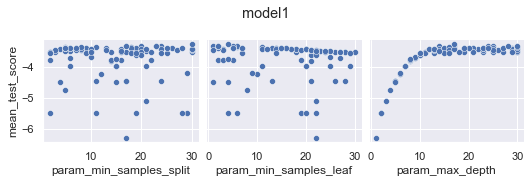

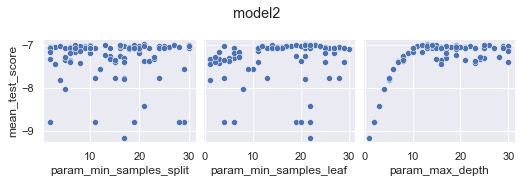

In [28]:
def feature_score(model, title):
    '''
    Функция визуализации зависимости метрики от параметров
    model - обученная модель
    title - заголовок графика
    '''
    results = pd.DataFrame(model.cv_results_)
    g = sns.pairplot(data=results,
                     x_vars=results.iloc[:, 4:-(9)].columns,
                     y_vars=['mean_test_score'],
                     diag_kind=None
                    )
    plt.subplots_adjust(top=0.8)
    g.fig.suptitle(title)
    plt.show()

feature_score(model1, 'model1')
feature_score(model2, 'model2')

Теперь попробуем модель случайного леса.

In [29]:
%%time
model = RandomForestRegressor(random_state=321)
parameters = {'max_depth': range(1, 31),
              'min_samples_leaf': range(1, 31),
              'min_samples_split': range(2, 31),
              'n_estimators': range(1, 102, 20) 
             }
model1, model2 = sMAPE_sum_calc(model, model, X1_train, y1_train, X2_train, y2_train, 321, parameters)

sMAPE на тренировочных данных = 2.5657236623126742
sMAPE на тренировочных данных = 5.650806649148609
Итоговое sMAPE = 4.879535902439625
Wall time: 41min 3s


Модель случайного леса показала результат ещё лучше, чем модель дерева решений. Но скорость обучения значительно меньше, чем у решающего дерева и линейной регрессии. Получим зависимость метрики от варьируемых параметров.

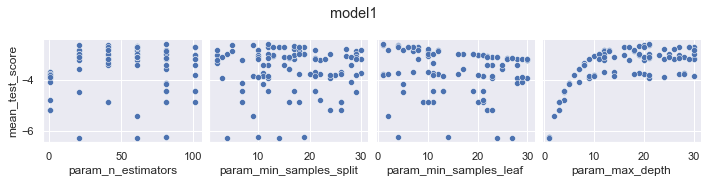

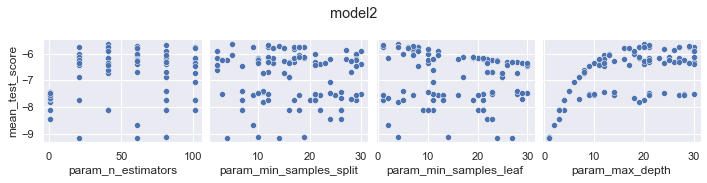

In [30]:
feature_score(model1, 'model1')
feature_score(model2, 'model2')

Таким образом оставляем модель случайного леса для предсказаний. 

<a id='section10'></a>

#### 4. Проверка лучшей модели на тестовых данных

Теперь проверим качество лучших моделей на тестовой выборке.

In [31]:
sMAPE_sum(sMAPE(y1_test, model1.predict(X1_test)), sMAPE(y2_test, model2.predict(X2_test)))

7.152969203339772

Итоговое sMAPE на тестовой выборке составило 7.15% - довольно хороший результат.

<a id='section11'></a>

#### 5. Проверка модели на адекватность

Теперь проверим модель на адекватность, сравнив её качество с качеством константной модели. Константная модель будет предсказывать всегда одно и то же медианное значение целевого признака. 

In [32]:
# Вычислим медианное значение целевых признаков тренировочной выборки.
y1_train_median = y1_train.median()
y2_train_median = y2_train.median()
y1_test_median_predict = pd.Series(y1_train_median, index=X1_test.index)
y2_test_median_predict = pd.Series(y2_train_median, index=X2_test.index)
sMAPE_sum(sMAPE(y1_test, y1_test_median_predict), sMAPE(y2_test, y2_test_median_predict))

7.37853550487379

Итоговое sMAPE константной модели оказалось хуже, чем у нашей лучшей модели. Таким образом адекватность нашей лучшей модели подтверждена.

### Вывод
Были написаны функции для вычисления sMAPE на каждом этапе обработки исходного сырья и для вычисления итогового sMAPE. С помощью кросс-валидации были отобраны только самые важные признаки для каждого целевого признака. Обучение различных моделей с использованием кросс-валидации показало, что лучшего результата удается добиться с помощью модели линейной регресии. Итоговое sMAPE составило 7,31%.

### Общий выводы
В ходе работы были получены следующие результаты:
1. Были изучены исходные данные, проведена проверка того, что эффективность обогащения рассчитана верно. Тестовые данные были дополнены недостающими целевыми признаками, из тренировочных удалены избыточные признаки. Затем все данные были предобработаны.
2. Был проведён исследовательский анализ данных. Показано, как меняется концентрация металлов на каждом этапе обработки, осущестлвено сравнение размеров исходного сырья в тренировочной и тестовой выборках. Были выявлены и удалены наблюдения с аномальными значениями суммарных концентраций веществ в различных фазах.
3. Была обучена модель линейной регрессии для предсказания итоговой эффективности обогащения. Итоговоый показатель sMAPE составил 7,15%.
<br>

Таким образом модель линейной регрессии лучше других подходит для предсказания эффективности обогащения.